In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch import nn, optim
from time import time
#Allows showing plots in notebook:
%matplotlib inline
from torchvision import datasets, transforms
#import imageio

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


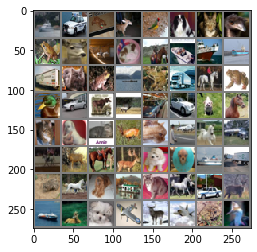

 ship   car   dog  deer


In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [14]:
print('the number of images in the train set:', len(trainset))
print('the number of images in the validation/test set:', len(testset))

dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

the number of images in the train set: 50000
the number of images in the validation/test set: 10000
torch.Size([64, 3, 32, 32])
torch.Size([64])


# Your code should go below:

### Defining CNN: (PLEASE MAKE CHANGES !

In [19]:
class cnn_net_bn_drop(nn.Module):
    def __init__(self):
        super(cnn_net_bn_drop, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5,padding=2),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2))
#         self.conv2_drop = nn.Dropout2d() #regularization method to prevent overfitting. 
        self.fc1 = nn.Linear(8*8*20, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dense1_bn = nn.BatchNorm1d(8*8*20)
        self.dense2_bn = nn.BatchNorm1d(128)
        self.lin_drop = nn.Dropout(0.2) #regularization method to prevent overfitting. 
    def forward(self, x):
        x = self.conv1(x) #F.max_pool2d(F.relu(self.conv1(x)),2)
        x = self.conv2(x)
        x = x.view(-1, 8*8*20)
        x = self.lin_drop(x)
        x = self.dense1_bn(x)
        x = self.fc1(x)
        x = self.lin_drop(x)
        x = self.dense2_bn(x)
        x = self.fc2(x)
        return F.log_softmax(x)



## Train and test functions:

In [20]:
def train_CNN(net,criterion,optimizer,epoch,trainloader):
    net.train() # When using dropout this is necessary! it states that we are on a training mode.
    for batch_idx, (data, target) in enumerate(trainloader):
        # gradient has to be manually set to zero because otherwise gradients are accumulated
        optimizer.zero_grad()
        # Calculates the output for some bach of figures
        output = net(data)
        # Calculates the loss
        loss = criterion(output, target)
        # This is where gradients are calculated (for the loss tensor)
        loss.backward()
        #And optimizes its weights here by some gradient decent like scheme
        optimizer.step()
        #Just to print how the progress is doing:
        if batch_idx % log_interval == 0:
            if batch_idx > 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))


### Defining function for testing

In [21]:
def test_CNN(net,criterion,testloader,batchsize=64,nsamples=10000):
    net.eval() # basically states that we are in evaluation mode. When using dropout necessary!
    test_loss = 0
    correct = 0
    flag_size = 0
    with torch.no_grad():
#    for data, target in testloader:
        for i, (data, target) in enumerate(testloader):
            output = net(data) # get predictions
            test_loss += criterion(output, target).item() # Sum over the losses 
            pred = output.data.max(1, keepdim=True)[1] # Get label with maximum probability
            correct += pred.eq(target.data.view_as(pred)).sum() #Comparing the true labels to the predicted labels
            if (i)*batchsize > nsamples: 
                flag_size = 1
                break
    if flag_size == 1:
        max_len = (i+1)*batchsize
    else:
        max_len = len(testloader.dataset)
    test_loss /= max_len
    test_losses.append(test_loss)
    print('\n Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, max_len,
    100. * correct / max_len))

In [26]:
log_interval = 100
learning_rate = 0.003
momentum = 0.5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

# network = cnn_net_bn_drop()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.NLLLoss() # Negative log liklihood loss function


n_epochs = 2 #Number of epocs
time0 = time()  
for epoch in range(1, n_epochs + 1):
    train_CNN(network,criterion,optimizer,epoch,trainloader)
    print("\nTraining Time for one epoch (in minutes) =",(time()-time0)/60)
    print('Performance on the train set:')
    test_CNN(network,criterion,trainloader)
    print('Performance on the test set:')
    test_CNN(network,criterion,testloader)

/Users/yani/anaconda3/envs/ML_IAP/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.137470
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.377643
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.207381
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.039675
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.167988
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.167808
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.256307

Training Time for one epoch (in minutes) = 0.8308938662211101
Performance on the train set:

 Avg. loss: 0.0167, Accuracy: 6325/10112 (62.55%)

Performance on the test set:

 Avg. loss: 0.0174, Accuracy: 6122/10000 (61.22%)

Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.073524
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.992433
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.957666
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.994858
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.875762
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.023420
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.959685

Training Time for one epoch (in minutes) = 1.7800271471341451
Performance o